In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from scipy.stats import skew
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./.config/default_configs.db
./.config/active_config
./.config/config_sentinel
./.config/.last_survey_prompt.yaml
./.config/.last_opt_in_prompt.yaml
./.config/.last_update_check.json
./.config/gce
./.config/logs/2023.10.03/13.24.45.667379.log
./.config/logs/2023.10.03/13.25.12.399084.log
./.config/logs/2023.10.03/13.25.40.579693.log
./.config/logs/2023.10.03/13.25.30.924211.log
./.config/logs/2023.10.03/13.25.22.293658.log
./.config/logs/2023.10.03/13.25.41.386955.log
./.config/configurations/config_default
./drive/MyDrive/my-test.ipynb
./drive/MyDrive/LR2.ipynb
./drive/MyDrive/CarPrice_Assignment.csv
./drive/MyDrive/_CS231n/assignments/assignment1/collectSubmission.sh
./drive/MyDrive/_CS231n/assignments/assignment1/makepdf.py
./drive/MyDrive/_CS231n/assignments/assignment1/two_layer_net.ipynb
./drive/MyDrive/_CS231n/assignments/assignment1/svm.ipynb
./drive/MyDrive/_CS231n/assignments/assignment1/collect_submission.ipynb
./drive/MyDrive/_CS231n/assignments/assignment1/features.ipynb
.

# **数据读取**

In [10]:
train = pd.read_csv('/content/drive/MyDrive/CarPrice_Assignment.csv')
# 数据预览
pd.set_option('display.max_columns', None)
train.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ****数据预处理****

In [12]:
# 数据清洗
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

**观察到数据完整性很好，无需补全缺失值**

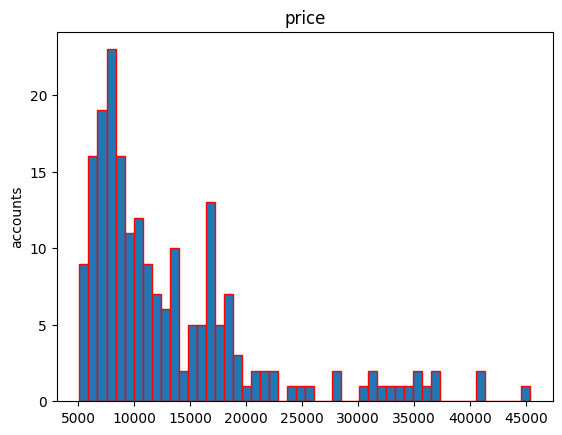

In [13]:
# 特征工程——因变量price
car_price = train.loc[:,'price']

plt.hist(car_price,bins=50,edgecolor="r")
plt.title("price")
plt.ylabel("accounts")

plt.show()

**观察到数据分布左偏，不符合正态分布的良好性质；考虑取对数**

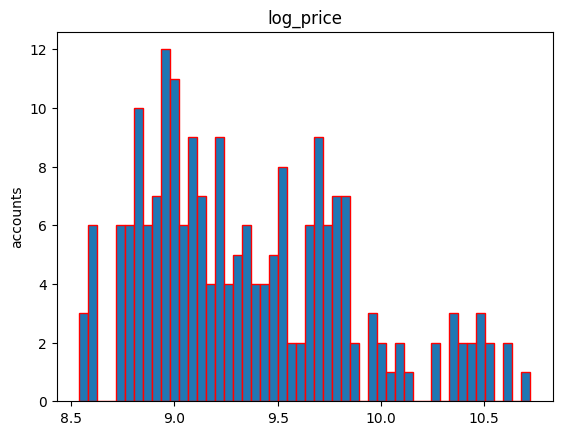

In [14]:
# 数据正态化处理
log_car_price = np.log1p(car_price)

plt.hist(log_car_price,bins=50,edgecolor="r")
plt.title("log_price")
plt.ylabel("accounts")

plt.show()

In [15]:
# 其他自变量正态化
all_data = train.copy()
#log transform skewed numeric features:
#找出df中数值型的变量
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
#compute skewness
#计算偏度，找出df中数值型变量中，偏度大于0.75这个阈值的特征
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
#对偏度较大的特征数据进行Log1p()转换。
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

**去除无关变量,从原始的26类中保留相关度高的18类特征。注意这里我没有进行类型的重分或者拆解,直接去除了carname**

In [16]:
new_data = all_data[['fueltype','aspiration','doornumber','carbody','drivewheel','enginetype','cylindernumber','fuelsystem'
             ,'wheelbase','carlength','carwidth','curbweight','enginesize','boreratio','horsepower','citympg','highwaympg',
             'price']]

**定类数据独热编码，增添哑变量**

In [17]:
new_data = pd.get_dummies(new_data, columns=["fueltype","aspiration","doornumber","carbody","drivewheel","enginetype","cylindernumber","fuelsystem"])

new_data.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,price,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,4.495355,168.8,4.175925,2548,4.875197,3.47,4.718499,21,27,9.510149,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,4.495355,168.8,4.175925,2548,4.875197,3.47,4.718499,21,27,9.711176,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,4.559126,171.2,4.197202,2823,5.030438,2.68,5.043425,19,26,9.711176,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,4.613138,176.6,4.207673,2337,4.700480,3.19,4.634729,24,30,9.543306,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,4.609162,176.6,4.210645,2824,4.919981,3.19,4.753590,18,22,9.767152,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


# **数据标准化**

In [18]:
scaler = StandardScaler()
col_names = ['wheelbase','carlength','carwidth','curbweight','enginesize','boreratio','horsepower','citympg','highwaympg']

new_data[col_names] = scaler.fit_transform(new_data[col_names])

**处理后数据预览**

In [19]:
new_data.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,price,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,-1.801353,-0.426521,-0.851698,-0.014566,0.237430,0.519071,0.365318,-0.646553,-0.546059,9.510149,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,-1.801353,-0.426521,-0.851698,-0.014566,0.237430,0.519071,0.365318,-0.646553,-0.546059,9.711176,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,-0.713827,-0.231513,-0.177732,0.514882,0.791580,-2.404880,1.319046,-0.953012,-0.691627,9.711176,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0.207276,0.207256,0.153949,-0.420797,-0.386244,-0.517266,0.119435,-0.186865,-0.109354,9.543306,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.139468,0.207256,0.248080,0.516807,0.397290,-0.517266,0.468318,-1.106241,-1.273900,9.767152,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


**按照训练集和测试集4:1的比例进行数据集划分**

In [20]:
X = new_data.drop(columns=["price"])
y = new_data["price"]

In [21]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

**预览分好的数据集shape**

In [22]:
print("x_train - >  ",x_train.shape)
print("x_test - >  ",x_test.shape)
print("y_train - >  ",y_train.shape)
print("y_test - >  ",y_test.shape)

x_train - >   (164, 45)
x_test - >   (41, 45)
y_train - >   (164,)
y_test - >   (41,)


# **模型训练**

In [23]:
# 直接调包
model = LinearRegression().fit(x_train,y_train,0.01)
x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

train_r2_score = r2_score(y_train,x_train_pred)*100
test_r2_score = r2_score(y_test,x_test_pred)*100
train_mse = mean_squared_error(y_train,x_train_pred)
test_mse = mean_squared_error(y_test,x_test_pred)
print(f"训练集上得分={train_r2_score}")
print(f"测试集上得分={test_r2_score}")
print(f"训练集上mse={train_mse}")
print(f"测试集上mse={test_mse}")

训练集上得分=93.4181269459119
测试集上得分=89.52089563405755
训练集上mse=0.01631343861263239
测试集上mse=0.028428208752406363


###　**自己动手实现**

**不使用正则化、L1正则化(LASSO回归)、L2正则化(Ridge回归/岭回归)的计算公式**

**计算Loss**

$不使用正则化:$

$$J(w,b)=\frac{1}{2m}\sum_{i=0}^{m-1}(f_{w,b}(x^{(i)})-y^{(i)})^2$$

$L1正则化(LASSO回归):$

$$J(w,b)=\frac{1}{2m}\sum_{i=0}^{m-1}(f_{w,b}(x^{(i)})-y^{(i)})^2+\frac{\lambda}{2m}\sum_{j=0}^{n-1}|w_j|$$

$L2正则化(Ridge回归/岭回归)$

$$J(w,b)=\frac{1}{2m}\sum_{i=0}^{m-1}(f_{w,b}(x^{(i)})-y^{(i)})^2+\frac{\lambda}{2m}\sum_{j=0}^{n-1}w_j^2$$

**计算梯度**

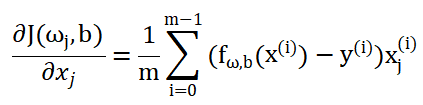
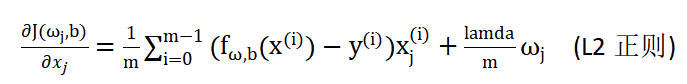

**预测结果**

$$f_{w,b}(x^{(i)})=w \cdot x^{(i)} + b$$

**Loss计算**

In [24]:
def compute_cost(X, y, w, b, lambda_ = 1, op = 0):
    """
    Computes cost using loss, non-matrix version

    """

    m,n = X.shape
    cost = 0.

    # 循环计算
#     for i in range(m):
#         f_wb_i = np.dot(X[i], w) + b                                   #(n,)(n,)=scalar, see np.dot
#         cost = cost + (f_wb_i - y[i])**2                               #Loss函数
#     cost = cost / (2 * m)

    # 矩阵计算速度会快
    f_wb_i = np.matmul(X, w) + b
    loss = np.square(f_wb_i.T - y)
    cost = loss.sum() / (2 * m)

    # 正则化，注意不包含b
    reg_cost = 0
    # 循环计算
#     for j in range(n):
#         reg_cost += (w[j]**2)
    # 矩阵计算
    if op == 0:
        return cost
    else:
        w_tmp = w
        if op == 1:
            w_tmp = np.abs(w)
        else:
            w_tmp = np.square(w)

        reg_cost = (lambda_/(2*m)) * w_tmp.sum()

        total_cost = cost + reg_cost
        return total_cost

**迭代梯度下降**

In [25]:
def compute_gradient(w, b, x_train, y_train, lambda_ = 1, op = 0):
    m,n = x_train.shape #(164, 45)

    dj_dw = np.zeros((n,))
    dj_db = 0.

    # 循环计算
    # for i in range(m):
    #     f_wb_i = np.dot(x_train[i],w) + b
    #     err_i  = f_wb_i  - y_train[i]
    #     #print(y_train[i].shape)
    #     for j in range(n):
    #         dj_dw[j] = dj_dw[j] + err_i * x_train[i,j]
    #     dj_db = dj_db + err_i

    # dj_dw = dj_dw/m
    # dj_db = dj_db/m

    # 矩阵并行计算
    f_wb = np.matmul(x_train,w) + b
    err = f_wb.T - y_train #164, 1

    dj_dw = np.array((err.T * x_train)/m)

    if op == 1:
        dj_dw += (lambda_ / (2*m)) * np.sign(w)
    elif op == 2:
        dj_dw += (lambda_ / m) * w
    dj_db = err.sum()/m
    dj_dw = np.squeeze(dj_dw.T)


    return dj_dw, dj_db

**迭代更新参数**

In [26]:
def updateParameters(w, b, x_train, y_train, alpha, iters, lamda_=1, op = 0):
    Epochs_list = []
    J_cost = []
    for i in range(iters):
        dj_dw, dj_db = compute_gradient(w, b, x_train, y_train, lamda_, op)
        w = w - (alpha * dj_dw) #numpy
        b = b - (alpha * dj_db)

        if i%1000 == 0 and i != 0:
            cost = compute_cost(x_train, y_train, w, b, lamda_, op)
            print(f"Iters:{i}***{cost}",)
            Epochs_list.append(i)
            J_cost.append(cost)

    # return w,b
    # 绘制收敛曲线
    plt.plot(Epochs_list,J_cost)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    return w,b

**我的手写线性回归模型**

In [27]:
class my_model():
    def __init__(self):
        self.ws = 0
        self.b = 0

    def fit(self, x_train, y_train, op, mylamda = 1.0):
        # 固定随机种子的随机化初始
        np.random.seed(42)
        w_in = np.random.rand(x_train.shape[1])
        b_in = np.random.rand()
        alpha = 0.1  # 学习率
        iters = 100000 # 迭代轮数
        lamda_ = mylamda # 正则化系数

        w_out, b_out = updateParameters(w_in, b_in, x_train, y_train, alpha, iters, lamda_, op)
        print(f"Final_alpha={alpha}_epochs={iters}_Cost={compute_cost(x_train, y_train, w_out, b_out, lamda_, op)}")

        self.ws = w_out
        self.b = b_out
        return 0

    def predict(self, x):
        x_pred = np.dot(x,self.ws) + self.b
        return x_pred


**运行；每1000epochs弹出一次loss，绘制收敛曲线，底部显示运行时间**

Iters:1000***0.11216707599179632
Iters:2000***0.07580345805993512
Iters:3000***0.0631925887835011
Iters:4000***0.053134903919158
Iters:5000***0.04473741302677038
Iters:6000***0.036410088264716305
Iters:7000***0.02835855474579595
Iters:8000***0.023413310990280628
Iters:9000***0.019286800714476103
Iters:10000***0.018723639932110132
Iters:11000***0.018671066556971795
Iters:12000***0.018664951144459138
Iters:13000***0.018664946699138346
Iters:14000***0.018664992234307995
Iters:15000***0.018667731054919413
Iters:16000***0.018670182280731164
Iters:17000***0.01866645958546256
Iters:18000***0.018658799187309873
Iters:19000***0.01867496901377833
Iters:20000***0.018662639700087615
Iters:21000***0.018668997845521406
Iters:22000***0.01866642202627795
Iters:23000***0.018669091642342754
Iters:24000***0.01866589624993628
Iters:25000***0.018664344726102296
Iters:26000***0.01867006019791252
Iters:27000***0.018666538590323984
Iters:28000***0.018666118833475947
Iters:29000***0.01866737602034115
Iters:300

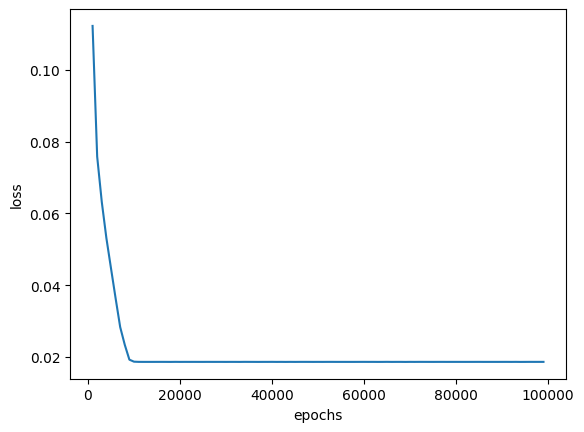

Final_alpha=0.1_epochs=100000_Cost=0.018669540085305247
运行时间=6.490743398666382


In [28]:
x_train_in = np.matrix(x_train)
y_train_in = np.matrix(y_train)
x_test_in = np.matrix(x_test)
y_test_in = np.matrix(y_test)

time_start = time.time()  # 记录开始时间

model = my_model()
model.fit(x_train_in,y_train_in.T,1,1.9)

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print(f"运行时间={time_sum}")


# 数据测试

In [29]:
x_train_pred = model.predict(x_train_in)
x_test_pred = model.predict(x_test_in)
my_train_score = r2_score(np.array(y_train_in).T,np.array(x_train_pred).T)*100
my_test_score = r2_score(np.array(y_test_in).T,np.array(x_test_pred).T)*100
my_train_mse = mean_squared_error(np.array(y_train_in).T,np.array(x_train_pred).T)
my_test_mse = mean_squared_error(np.array(y_test_in).T,np.array(x_test_pred).T)
print(f"训练集上得分={my_train_score}")
print(f"测试集上得分={my_test_score}")
print(f"训练集上mse={my_train_mse}")
print(f"测试集上mse={my_test_mse}")

训练集上得分=89.7387597402405
测试集上得分=90.5729813910171
训练集上mse=0.025432899068614866
测试集上mse=0.02557406087107743


**观察残差分布情况**

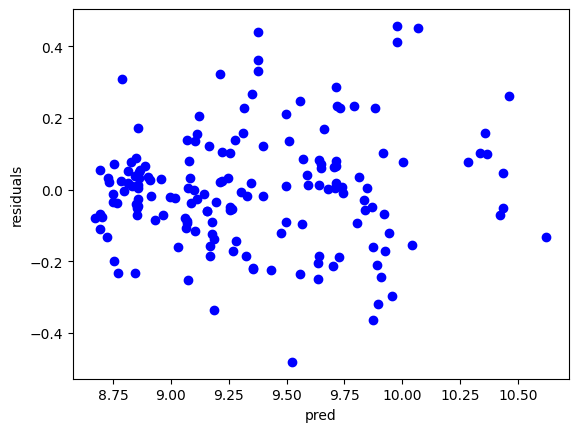

In [30]:
xx = np.array(x_train_pred.flatten())
yy = np.array(y_train_in.flatten())
residuals = yy-xx
plt.xlabel('pred')
plt.ylabel('residuals')
plt.scatter(xx, residuals, c='blue', edgecolors='blue', alpha=1)
plt.show()
#观察残差分布（理想的分布应为正态分布）

# 参数保存

In [31]:
w_t = model.ws
b_t = np.array([model.b])

w_t = pd.DataFrame(w_t)
b_t = pd.DataFrame(b_t)

output= pd.concat([w_t, b_t], axis=1, ignore_index=True) #按照列拼

output.to_csv('result_paras.csv', index=False)

**与真实值对比**

In [32]:
xx = pd.DataFrame(x_test_pred.T)
yy = pd.DataFrame(y_test_in.T)
df = pd.concat([xx, yy], axis=1, ignore_index=True) #按照列拼
df.columns = ['pred', 'real']

df.to_csv('result_price.csv', index=False)

**不同正则化系数对结果的影响**

In [33]:

score1,score2,mse1,mse2=[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]
if False:
	for op in range(3):
		flg = True
		model = my_model()
		for lamda_ in np.linspace(0.0,5.0,51):
			if op or flg:
				model = my_model()
				model.fit(x_train_in,y_train_in.T,op,lamda_)
			flg = False
			x_train_pred = model.predict(x_train_in)
			x_test_pred = model.predict(x_test_in)
			my_train_score = r2_score(np.array(y_train_in).T,np.array(x_train_pred).T)*100
			my_test_score = r2_score(np.array(y_test_in).T,np.array(x_test_pred).T)*100
			my_train_mse = mean_squared_error(np.array(y_train_in).T,np.array(x_train_pred).T)
			my_test_mse = mean_squared_error(np.array(y_test_in).T,np.array(x_test_pred).T)
			score1[op].append(my_train_score)
			score2[op].append(my_test_score)
			mse1[op].append(my_train_mse)
			mse2[op].append(my_test_mse)
			print(f"op={op} lambda={lamda_}")



In [34]:
if False:
	plt.plot(np.linspace(0.0,5.0,51),score1[0],label="OLS train",color='red',linestyle='--',alpha=0.8)
	plt.plot(np.linspace(0.0,5.0,51),score1[1],label="Lasso train",color='orange',linestyle='--',alpha=0.8)
	plt.plot(np.linspace(0.0,5.0,51),score1[2],label="Ridg train",color='cyan',linestyle='--',alpha=0.8)
	plt.plot(np.linspace(0.0,5.0,51),score2[0],label="OLS test",color='red')
	plt.plot(np.linspace(0.0,5.0,51),score2[1],label="Lasso test",color='orange')
	plt.plot(np.linspace(0.0,5.0,51),score2[2],label="Ridge test",color='cyan')
	plt.legend(loc="best")
	plt.xlabel('lambda')
	plt.ylabel('r2_score')
	plt.show()

	plt.plot(np.linspace(0.0,5.0,51),mse1[0],label="OLS train",color='red',linestyle='--',alpha=0.8)
	plt.plot(np.linspace(0.0,5.0,51),mse1[1],label="Lasso train",color='orange',linestyle='--',alpha=0.8)
	plt.plot(np.linspace(0.0,5.0,51),mse1[2],label="Ridge train",color='cyan',linestyle='--',alpha=0.8)
	plt.plot(np.linspace(0.0,5.0,51),mse2[0],label="OLS test",color='red')
	plt.plot(np.linspace(0.0,5.0,51),mse2[1],label="Lasso test",color='orange')
	plt.plot(np.linspace(0.0,5.0,51),mse2[2],label="Ridge test",color='cyan')
	plt.legend(loc="best")
	plt.xlabel('lambda')
	plt.ylabel('mse')
	plt.show()